# 1. Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np

# 2. Импорт данных

In [2]:
df = pd.read_csv('vehicles.csv')

In [51]:
data = df.copy()

### Сразу же сделаем разбиение на train и тест,чтобы в дальнейшем избежать утечку данных

In [52]:
df_train,df_test = train_test_split(data,test_size=0.2)

###  Описание признаков датасета

- **id** — уникальный идентификатор объявления  
- **url** — ссылка на объявление  
- **region** — регион, где продаётся авто  
- **region_url** — ссылка на страницу региона  
- **price** — цена автомобиля (целевая переменная)  
- **year** — год выпуска  
- **manufacturer** — производитель (марка авто)  
- **model** — модель автомобиля  
- **condition** — состояние автомобиля  
- **cylinders** — количество цилиндров двигателя  
- **fuel** — тип топлива  
- **odometer** — пробег  
- **title_status** — статус документа (clean, salvage и др.)  
- **transmission** — коробка передач  
- **VIN** — VIN-номер автомобиля  
- **drive** — тип привода (FWD, RWD, AWD)  
- **size** — размер автомобиля (compact, full-size и т. д.)  
- **type** — тип кузова (sedan, SUV, truck и т. д.)  
- **paint_color** — цвет автомобиля  
- **image_url** — ссылка на фотографию  
- **description** — текстовое описание объявления  
- **county** — округ (все значения отсутствуют)  
- **state** — штат (для США)  
- **lat** — широта  
- **long** — долгота  
- **posting_date** — дата публикации объявления  


### Переведем колонки cylinders и posting_date в другие форматы,для более удобного анализа

In [55]:
# Преобразование цилиндров
df_train['cylinders_num'] =  df_train['cylinders'].str.extract('(\d+)')
df_train['cylinders_num'] = df_train['cylinders_num'].astype(float)

# Создание новых числовых признаков
df_train['posting_date'] = pd.to_datetime(df_train['posting_date'], errors='coerce', utc=True)
df_train['posting_year'] = df_train['posting_date'].dt.year
df_train['posting_month'] = df_train['posting_date'].dt.month
df_train['posting_day'] = df_train['posting_date'].dt.day
df_train['posting_weekday'] = df_train['posting_date'].dt.weekday  
df_train['posting_hour'] = df_train['posting_date'].dt.hour

# 3. Первоначальный отбор признаков и заполенение пропущенные значений

### Посмотрим на количесвто уникальных значений для каждой колонки

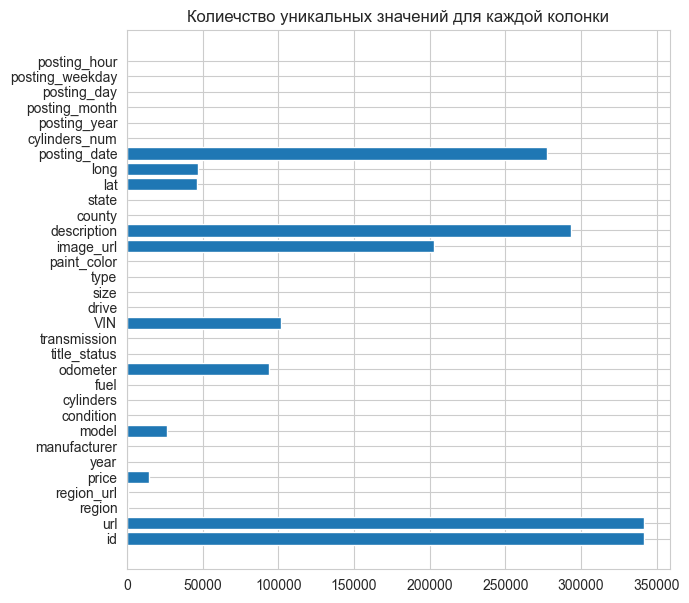

In [56]:
plt.figure(figsize=(7,7))
plt.barh(df_train.columns,df_train.nunique())
plt.title('Колиечство уникальных значений для каждой колонки')
plt.show()

### Исходя из описания признаков сразу можно выделить неинформативные признаки,которые являются уникальными значениями.Удалим их

In [57]:
df_train.drop(columns=['id', 'url', 'image_url', 'region_url','VIN'],inplace=True)

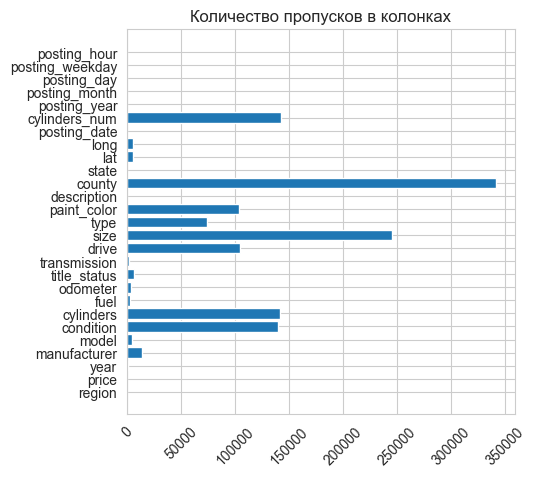

In [58]:
missing_counts = df_train.isnull().sum()
plt.figure(figsize=(5,5))
plt.barh(missing_counts.index,missing_counts)
plt.title('Количество пропусков в колонках')
plt.xticks(rotation=45)  
plt.show()

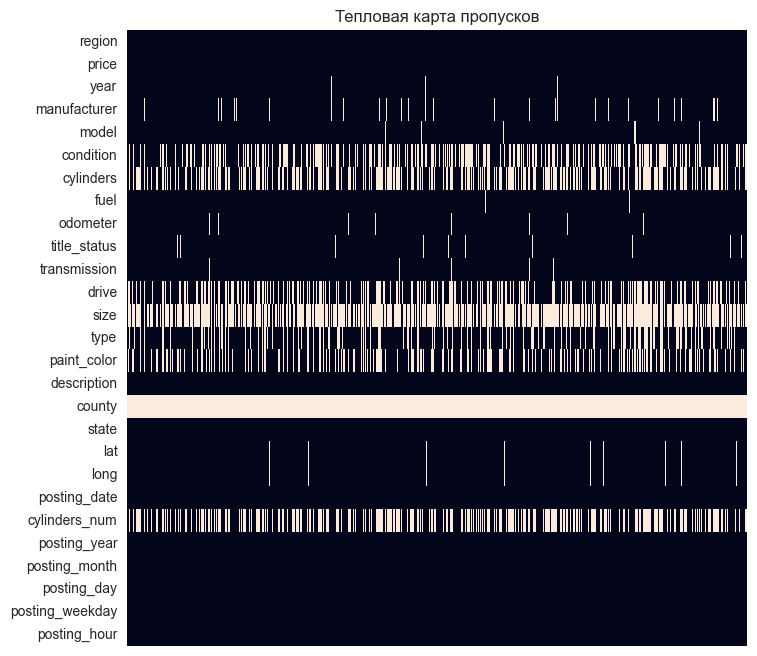

In [59]:
plt.figure(figsize=(8,8))
sns.heatmap(df_train.isna().T, cbar=False, xticklabels=False)
plt.title('Тепловая карта пропусков')
plt.show()

### По графику и тепловой карте видно,что пропусков в некоторых колонках довольно много. Именно поэтому целесообразно будет удалить колонки где процент пропущенных значений превышает 70%

In [60]:
def find_col_to_del(data:pd.DataFrame):
    all_k = data.shape[0]
    cols_with_null = data.columns[data.isnull().sum() > 0].tolist()
    cols_to_drop = []
    for col in cols_with_null:
        if (data[col].isnull().sum() / all_k) * 100 > 70:
            cols_to_drop.append(col)
    return cols_to_drop

cols_to_drop = find_col_to_del(data=df_train)
df_train.drop(columns=cols_to_drop,inplace=True)

### Также удалим строчки,которые являются неинформативными,то есть те,в которых больше 70% признаков отсутсвут

In [61]:
df_train = df_train.dropna(thresh=int((df_train.shape[1] / 100) * 70))

## Заполнение пропусков

### Числовые

In [62]:
def find_num_col_to_fill(data: pd.DataFrame):
    num_cols = data.select_dtypes(exclude=['object'])
    num_cols_with_null = num_cols.columns[num_cols.isnull().any()].tolist()
    return  num_cols_with_null

num_cols_to_fil = find_num_col_to_fill(df_train)

df_train[num_cols_to_fil] = df_train[num_cols_to_fil].fillna(df_train[num_cols_to_fil].mean())

### Категориальные 

In [63]:
def find_cot_col_to_fill(data: pd.DataFrame):
    cot_cols = data.select_dtypes(include=['object'])
    cot_cols_with_null = [col for col in cot_cols.columns if cot_cols[col].isnull().any() and col != 'description']
    return cot_cols_with_null

cot_cols_to_fil = find_cot_col_to_fill(df_train)
df_train[cot_cols_to_fil] = df_train[cot_cols_to_fil].fillna('unknown')
df_train['description'] = df_train['description'].fillna('')

# 4. Исследуем числовые признаки  на выбросы

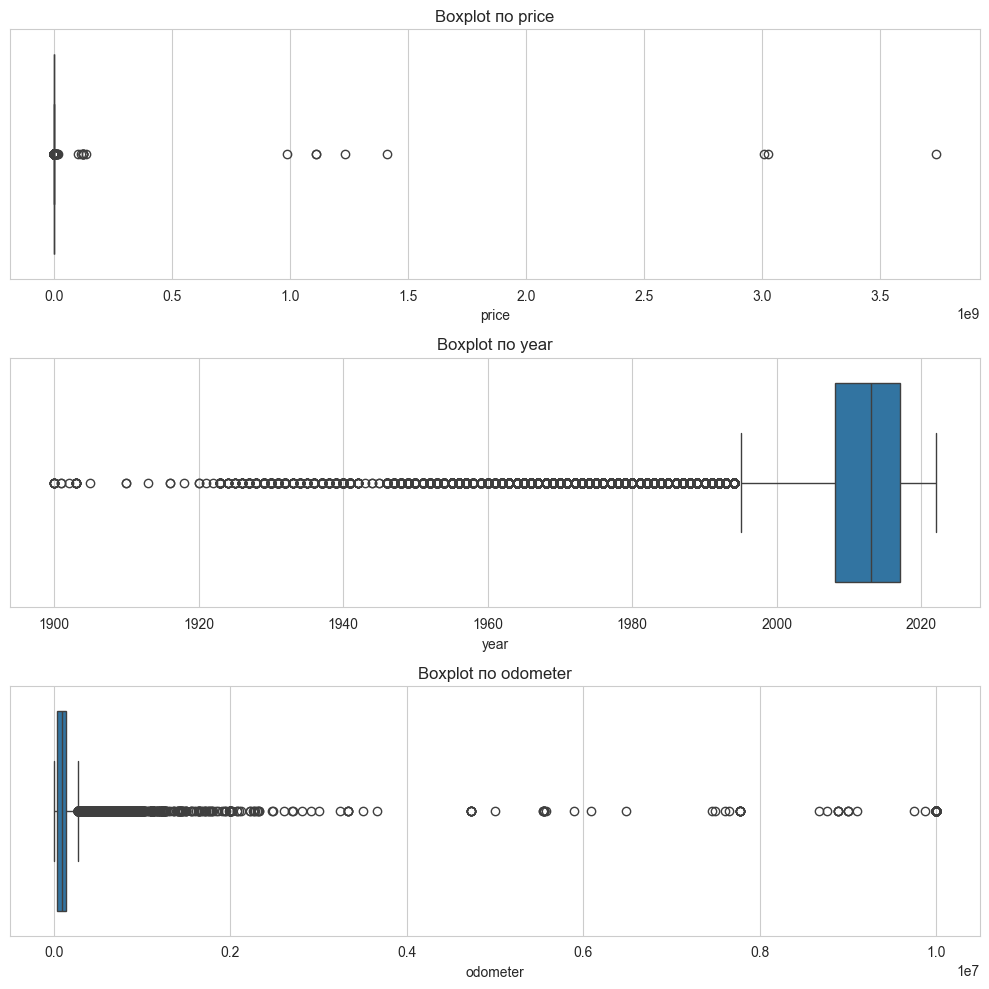

In [64]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

sns.boxplot(x=df_train['price'], ax=ax[0])
ax[0].set_title('Boxplot по price')

sns.boxplot(x=df_train['year'], ax=ax[1])
ax[1].set_title('Boxplot по year')

sns.boxplot(x=df_train['odometer'], ax=ax[2])
ax[2].set_title('Boxplot по odometer')

plt.tight_layout()
plt.show()

### Наглядно видно,что в данных присутствуют выбросы,от которых нужно непременно избавиться.Для начала сделаем предварительное ограничение по цене и пробегу.Далее рассмотрим каждый признак отдельно для более точечного определения границ

In [66]:
df_train = df_train[(df_train['price'] <= 500_000) & (df_train['price'] >= 100)]
df_train = df_train[df_train['odometer'] <= 600_000]

## Также рассмотрим координаты на выбросы

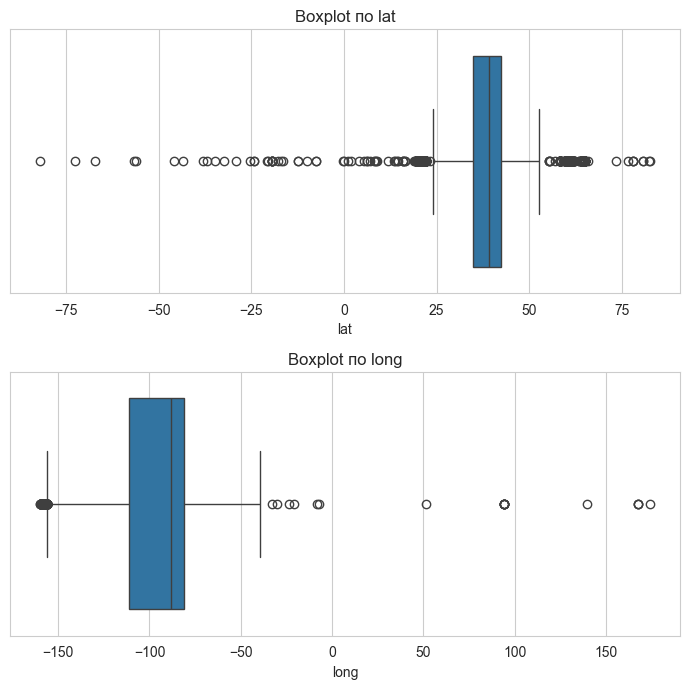

In [67]:
fig, ax = plt.subplots(2, 1, figsize=(7, 7))

sns.boxplot(x=df_train['lat'], ax=ax[0])
ax[0].set_title('Boxplot по lat')

sns.boxplot(x=df_train['long'], ax=ax[1])
ax[1].set_title('Boxplot по long')


plt.tight_layout()
plt.show()

### Также видим,что имеются выбросы которые стоит удалить 

## 4.1 Price 

### Так как price это целевая переменная,то её распределение и статистическе показазатели стоит рассмотреть более подробно

In [68]:
df_train['price'].describe()

count    311348.000000
mean      19081.138417
std       15321.730290
min         100.000000
25%        7499.000000
50%       15590.000000
75%       27950.000000
max      470000.000000
Name: price, dtype: float64

### Cреднее (mean) >> медиана (50% = 13987).Следовательно,распределение сильно смещено вправо, есть очень дорогие автомобили, которые тянут среднее вверх

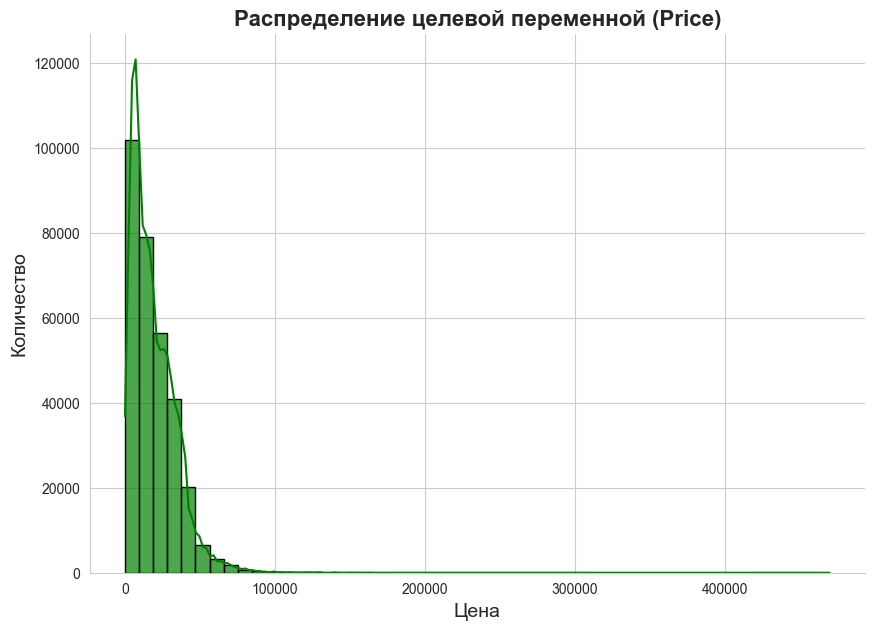

In [69]:
plt.figure(figsize=(10, 7))

sns.set_style("whitegrid")

sns.histplot(df_train['price'],bins=50, kde=True,color="green",edgecolor="black", alpha=0.7)

plt.title("Распределение целевой переменной (Price)", fontsize=16, fontweight='bold')
plt.xlabel("Цена", fontsize=14)
plt.ylabel("Количество", fontsize=14)

sns.despine()

plt.show()

### Наглядно видим смещение целевой переменной вправо.Также можно заметить,что машин с ценой больше 100_000 очень мало.Нужно подумать о логарифмическом преобразовании цены, чтобы модель лучше обучалась и метрики были стабильнее

## 4.2 Year

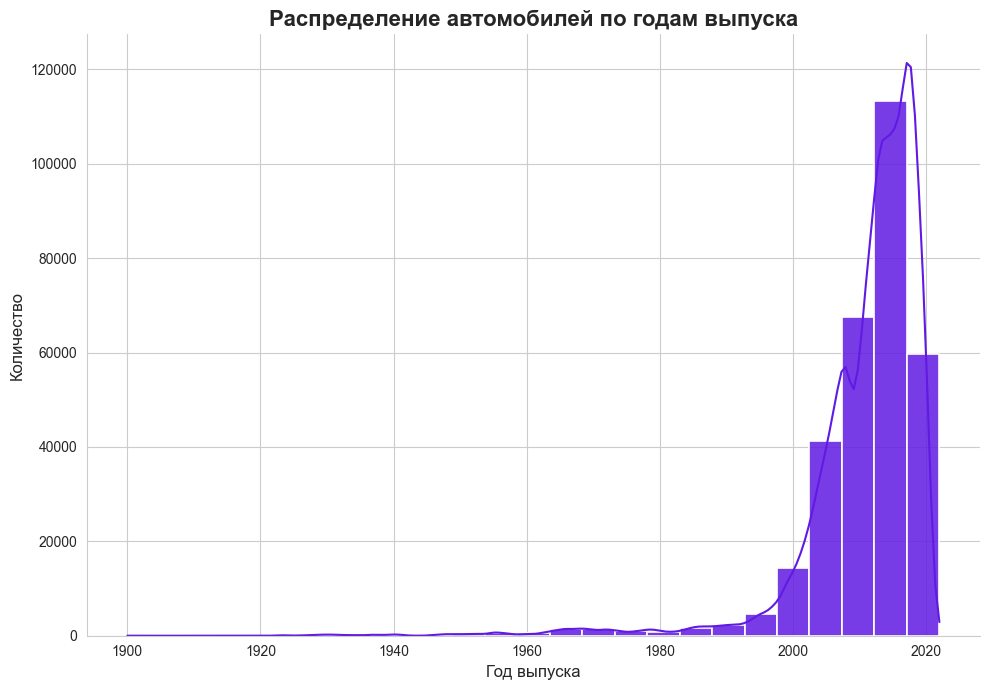

In [70]:
plt.figure(figsize=(10, 7))

sns.histplot(df_train['year'],kde=True, color="#601AE3", edgecolor="white", linewidth=1.2, alpha=0.85,bins=25)

plt.title("Распределение автомобилей по годам выпуска", fontsize=16,fontweight='bold')

plt.xlabel("Год выпуска", fontsize=12)
plt.ylabel("Количество", fontsize=12)

sns.despine()

plt.tight_layout()
plt.show()

### Заметим,что до 1980 года выпуск машин минимален. Возможно,следует удалить все объявления с машинами выпущенными раньше 1950 года 

## 4.3 Odometer

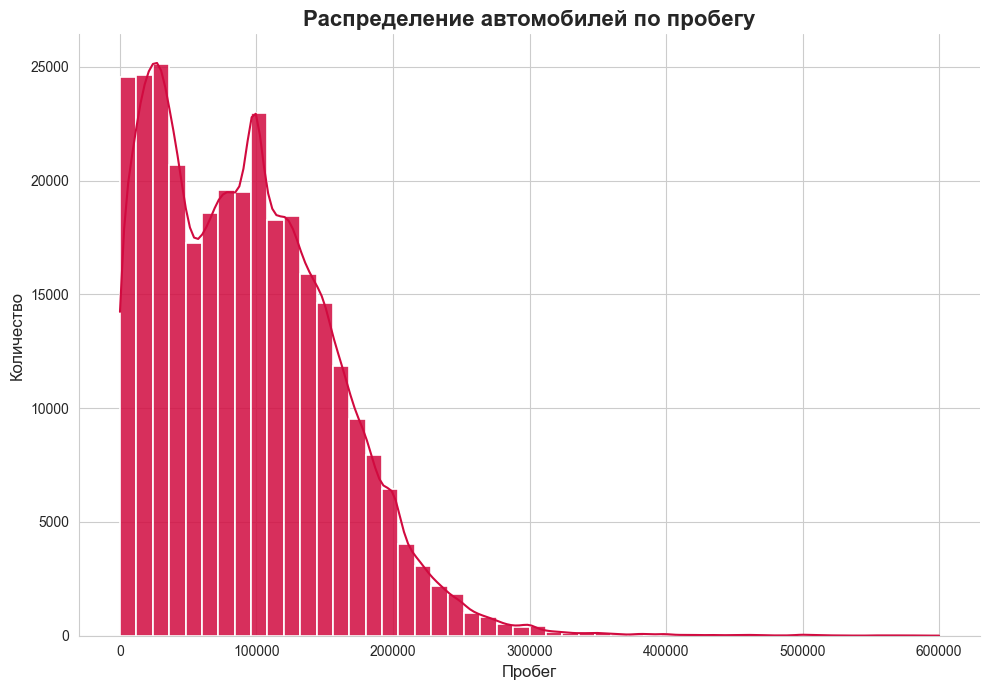

In [71]:
plt.figure(figsize=(10, 7))

sns.histplot(df_train['odometer'],kde=True, color="#D10A3F", edgecolor="white", linewidth=1.2, alpha=0.85,bins=50)

plt.title("Распределение автомобилей по пробегу", fontsize=16,fontweight='bold')

plt.xlabel("Пробег", fontsize=12)
plt.ylabel("Количество", fontsize=12)

sns.despine()

plt.tight_layout()
plt.show()

### Заметим,что количество машин с пробегом более 500_000 ничтожно мало и следовало бы удалить все значения превышаюшие этот показатель.

## 4.4 Координаты

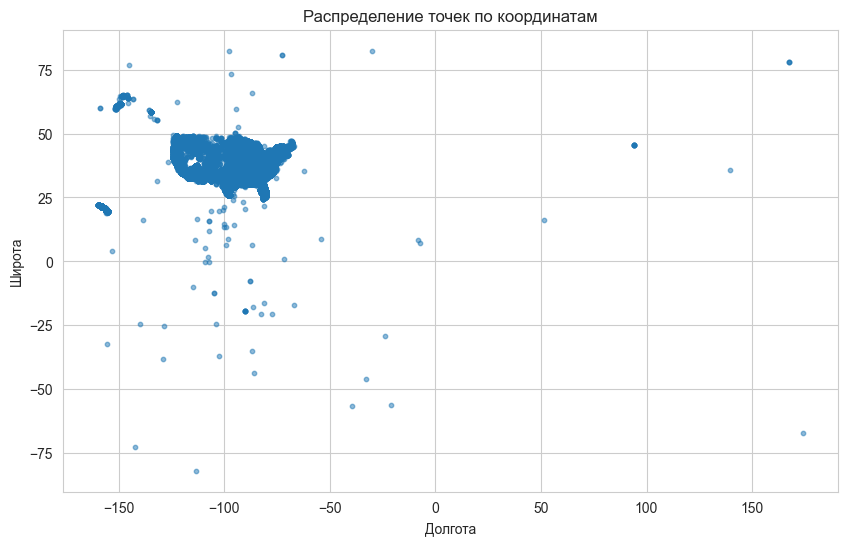

In [72]:
plt.figure(figsize=(10,6))
plt.scatter(x=df_train['long'],y=df_train['lat'], alpha=0.5, s=10)
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.title('Распределение точек по координатам')
plt.show()

### Наглядно видно,что в координатах также присутсвуют выбросы,которые следует удалить

# 5. Очистка от выбросов

### Ранее на основе графиков были сделаны предварительные предположения о том, какие значения следует удалить. Однако такой подход остаётся субъективным. Для более объективного и воспроизводимого отбора выбросов я применю метод IQR с кастомными квантилями. Это позволит формально выделить аномалии и гибко настроить границы через коэффициент k, избегая чрезмерного удаления данных.Также это поможет провести более объективный анализ числовых признаков.

In [73]:
def delete_by_IQR(data: pd.DataFrame, column: str, q_low: float = 0.25, q_high: float = 0.75) -> None:
    if column not in data.columns:
        print(f"Колонка '{column}' не найдена в DataFrame")
    
    else:
        Q1 = data[column].quantile(q_low)
        Q3 = data[column].quantile(q_high)
        IQR = Q3 - Q1

        low_border = Q1 - 1.5 * IQR
        high_border = Q3 + 1.5 * IQR

        before = len(data)
        data.drop(data[(data[column] < low_border) | (data[column] > high_border)].index, inplace=True)
        after = len(data)
        print(f"'{column}': удалено {before - after} выбросов")


df_train_clean = df_train.copy()
for col in ['year', 'price', 'odometer','long','lat','Log_price']:
    delete_by_IQR(df_train_clean, col, q_low=0.1, q_high=0.90)


'year': удалено 5905 выбросов
'price': удалено 689 выбросов
'odometer': удалено 267 выбросов
'long': удалено 11 выбросов
'lat': удалено 44 выбросов
Колонка 'Log_price' не найдена в DataFrame


### Посторим на размер датасета после всех удалений

In [74]:
print('Размер датасета: ',df_train_clean.shape)

Размер датасета:  (304432, 25)


## 5.1 Price

### Посмотрим на графики после очистки от выбросов

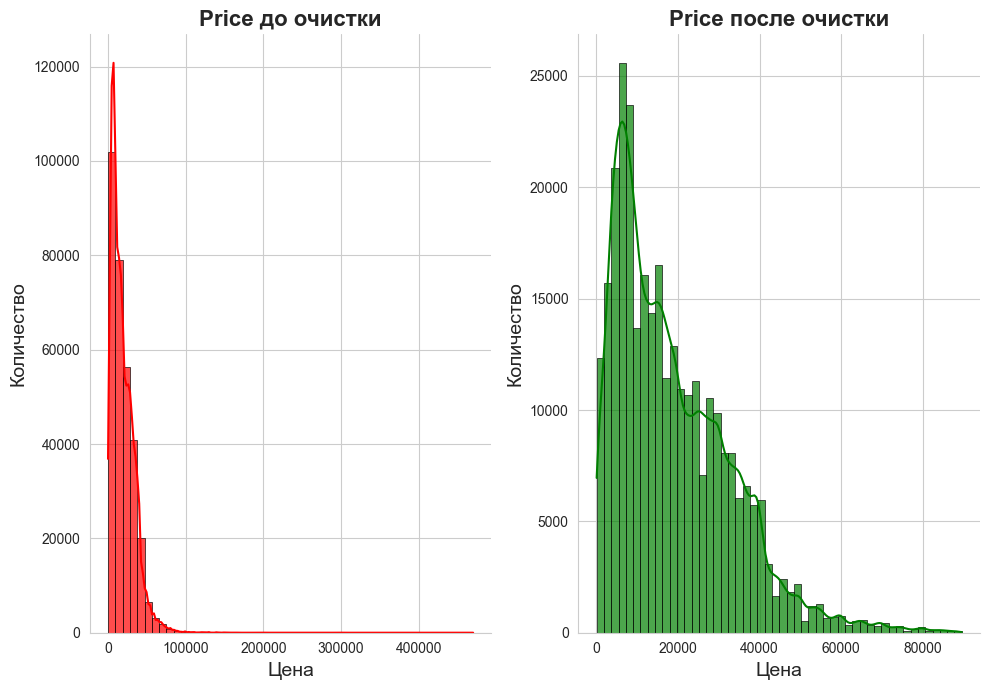

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

sns.set_style("whitegrid")

sns.histplot(df_train['price'],bins=50, kde=True,color="red",edgecolor="black", alpha=0.7,ax=ax[0])
ax[0].set_title("Price до очистки", fontsize=16, fontweight='bold')
ax[0].set_xlabel("Цена", fontsize=14)
ax[0].set_ylabel("Количество", fontsize=14)

sns.histplot(df_train_clean['price'],bins=50, kde=True,color="green",edgecolor="black", alpha=0.7,ax=ax[1])
ax[1].set_title("Price после очистки", fontsize=16, fontweight='bold')
ax[1].set_xlabel("Цена", fontsize=14)
ax[1].set_ylabel("Количество", fontsize=14)


sns.despine()
plt.tight_layout()
plt.show()

### Попробуем логарифмировать целевую переменную

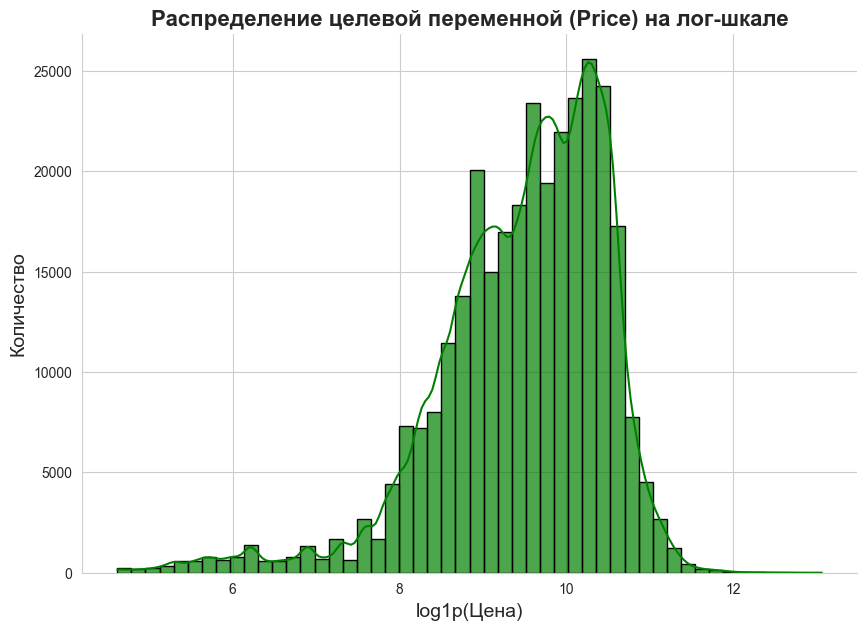

In [97]:
plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")

# Логарифмированная целевая переменная
sns.histplot(np.log1p(df_train['price']), bins=50, kde=True, color="green", edgecolor="black", alpha=0.7, label='log1p(price)')

plt.title("Распределение целевой переменной (Price) на лог-шкале", fontsize=16, fontweight='bold')
plt.xlabel("log1p(Цена)", fontsize=14)
plt.ylabel("Количество", fontsize=14)


sns.despine()
plt.show()

### Заметим,что распределение стало намного ближе к нормальному,поэтому бдует разумно прологарифмировать целевую переменную при обучении.

## 5.2 Year

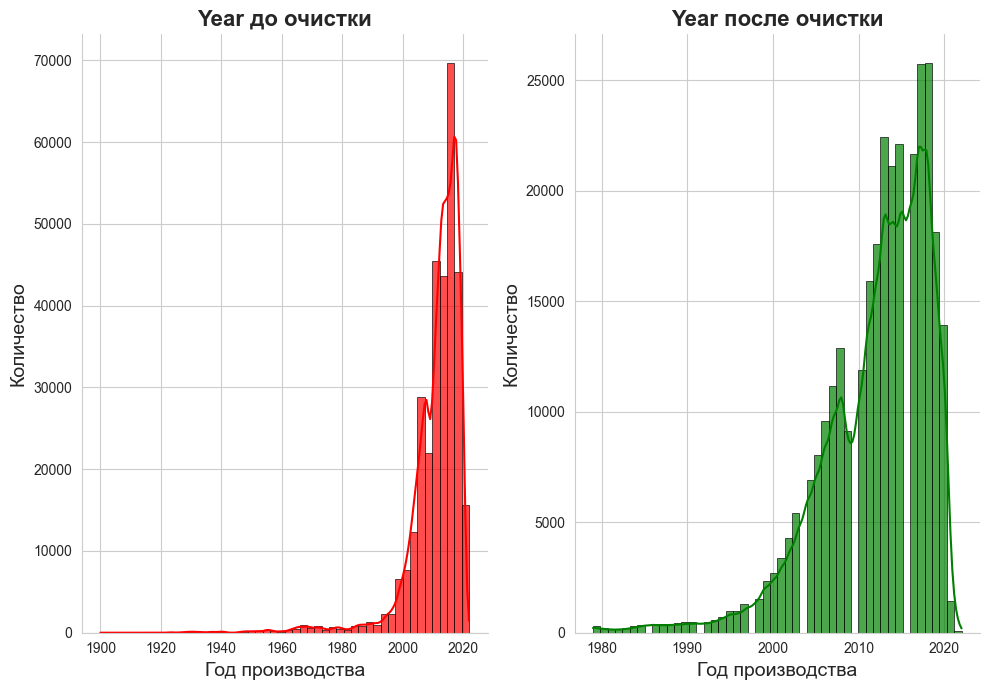

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

sns.set_style("whitegrid")

sns.histplot(df_train['year'],bins=50, kde=True,color="red",edgecolor="black", alpha=0.7,ax=ax[0])
ax[0].set_title("Year до очистки", fontsize=16, fontweight='bold')
ax[0].set_xlabel("Год производства", fontsize=14)
ax[0].set_ylabel("Количество", fontsize=14)

sns.histplot(df_train_clean['year'],bins=50, kde=True,color="green",edgecolor="black", alpha=0.7,ax=ax[1])
ax[1].set_title("Year после очистки", fontsize=16, fontweight='bold')
ax[1].set_xlabel("Год производства", fontsize=14)
ax[1].set_ylabel("Количество", fontsize=14)


sns.despine()
plt.tight_layout()
plt.show()

## 5.3 Odometer

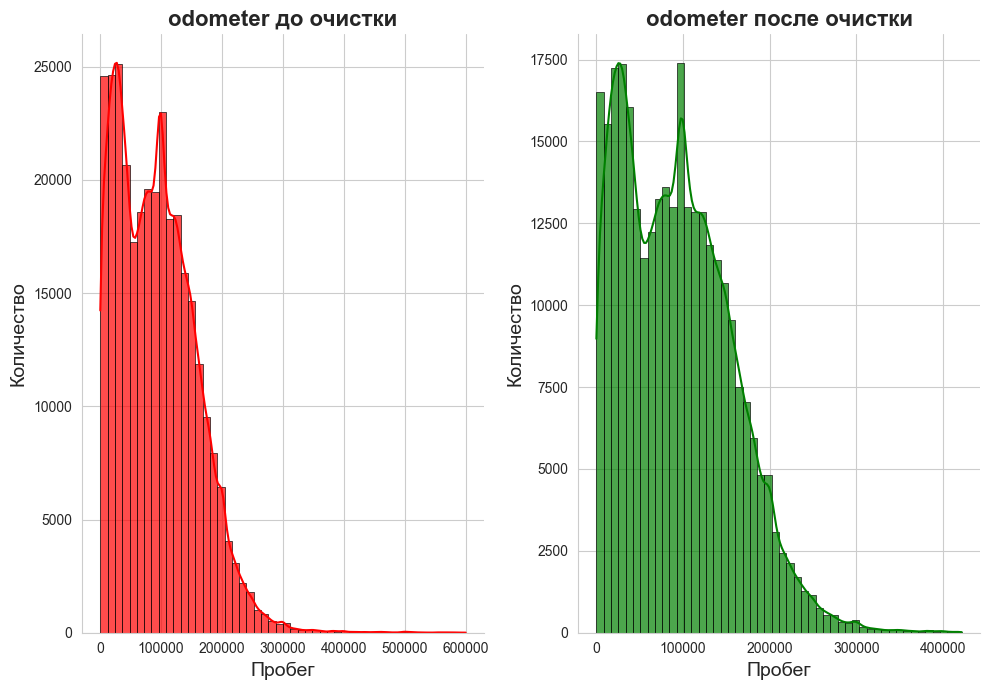

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

sns.set_style("whitegrid")

sns.histplot(df_train['odometer'],bins=50, kde=True,color="red",edgecolor="black", alpha=0.7,ax=ax[0])
ax[0].set_title("odometer до очистки", fontsize=16, fontweight='bold')
ax[0].set_xlabel("Пробег", fontsize=14)
ax[0].set_ylabel("Количество", fontsize=14)

sns.histplot(df_train_clean['odometer'],bins=50, kde=True,color="green",edgecolor="black", alpha=0.7,ax=ax[1])
ax[1].set_title("odometer после очистки", fontsize=16, fontweight='bold')
ax[1].set_xlabel("Пробег", fontsize=14)
ax[1].set_ylabel("Количество", fontsize=14)


sns.despine()
plt.tight_layout()
plt.show()

## 5.4 Координаты

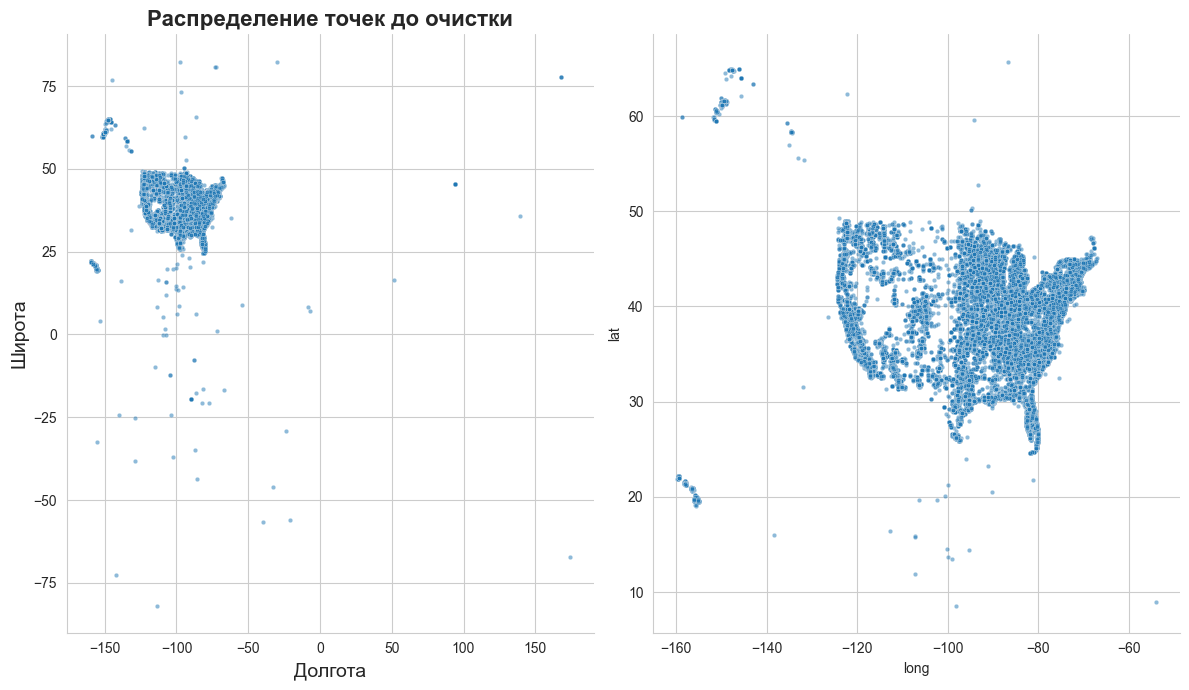

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))

sns.set_style("whitegrid")

sns.scatterplot(x = df_train['long'],y=df_train['lat'], alpha=0.5, s=10,ax=ax[0])
ax[0].set_title("Распределение точек до очистки", fontsize=16, fontweight='bold')
ax[0].set_xlabel("Долгота", fontsize=14)
ax[0].set_ylabel("Широта", fontsize=14)

sns.scatterplot(x = df_train_clean['long'],y=df_train_clean['lat'], alpha=0.5, s=10,ax=ax[1])
ax[0].set_title("Распределение точек до очистки", fontsize=16, fontweight='bold')
ax[0].set_xlabel("Долгота", fontsize=14)
ax[0].set_ylabel("Широта", fontsize=14)

sns.despine()
plt.tight_layout()
plt.show()

### По графикам видим,что все числовые признаки пришли в нормальные диапазоны,с котоырми можно работать

# 6. Посмотрим на возможные зависимости между числовыми признаками

## 6.1  Для начала рассмотрим зависимость цены от пробега

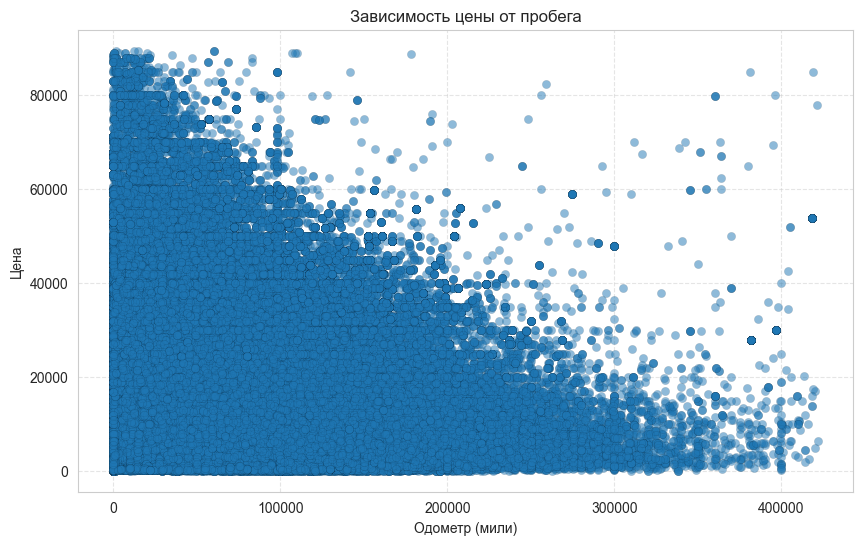

In [80]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,6))
plt.scatter(df_train_clean['odometer'], df_train_clean['price'], alpha=0.5,edgecolor='black',linewidth=0.1) 
plt.xlabel('Одометр (мили)')
plt.ylabel('Цена')
plt.title('Зависимость цены от пробега')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


### Заметим,что цена почти не зависит от пробега,т.к в нашем датасете есть и грузовые автомобили,пробег которых сильно больше легковых и цена на них также изменяется по другому закону

## 6.2 Рассмотрим зависимости цены от года выпуска автомобиля

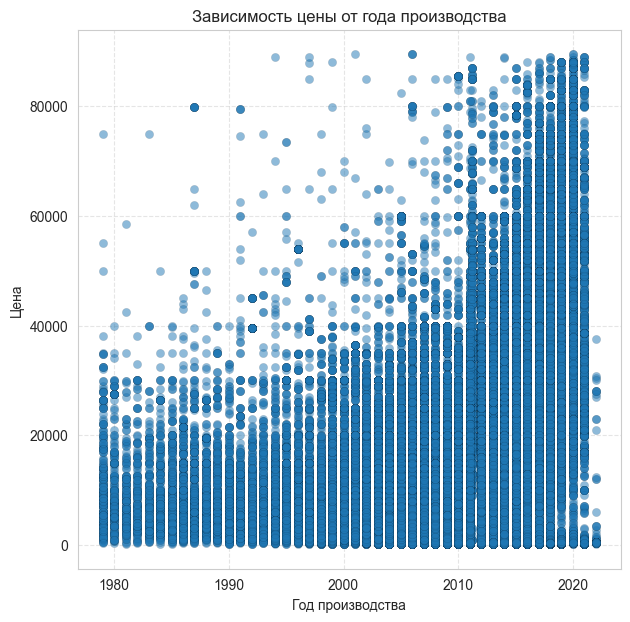

In [81]:
plt.figure(figsize=(7,7))
plt.scatter(df_train_clean['year'],df_train_clean['price'],alpha=0.5,edgecolor='black',linewidth=0.1)
plt.title('Зависимость цены от года производства')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylabel('Цена')
plt.xlabel('Год производства')
plt.show()

## 6.3 Рассмотрим зависимость пробега от года производства 

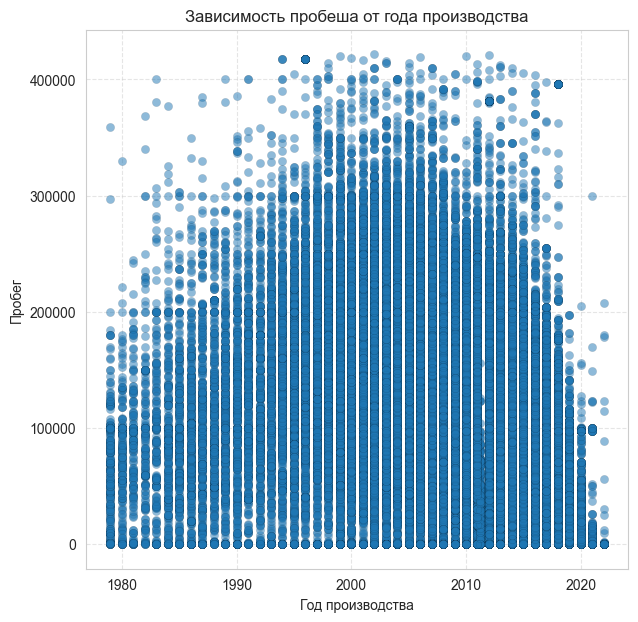

In [82]:
plt.figure(figsize=(7,7))
plt.scatter(df_train_clean['year'],df_train_clean['odometer'],alpha=0.5,edgecolor='black',linewidth=0.1)
plt.title('Зависимость пробеша от года производства')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylabel('Пробег')
plt.xlabel('Год производства')
plt.show()

## 6.4 проверим наши гипотезы построив матрицу корреляций

price: std = 14263.5086, unique = 13913
year: std = 6.4491, unique = 45
odometer: std = 63402.8859, unique = 86671
lat: std = 5.7778, unique = 42897
long: std = 18.0147, unique = 43413
cylinders_num: std = 1.2202, unique = 8
posting_year: std = 0.0000, unique = 1
posting_month: std = 0.4415, unique = 2
posting_day: std = 10.1036, unique = 30
posting_weekday: std = 1.9896, unique = 7
posting_hour: std = 5.8893, unique = 24
log_price: std = 1.0146, unique = 13913


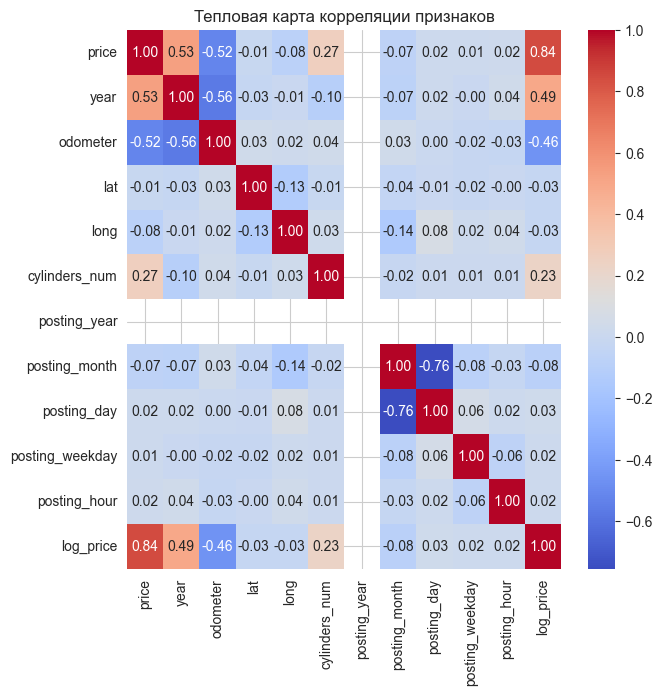

In [ ]:
corr_matrix_numbers = df_train_clean.select_dtypes(include=['int','float64']).corr()
plt.figure(figsize=(7, 7))
sns.heatmap(corr_matrix_numbers annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Тепловая карта корреляции признаков")
plt.show()

# 7. Проанализируем категориальные признаки

## 7.1 Для начала рассмотрим вариативность регионов в объявлениях

In [84]:
print('Количество уникальных регинонов:',len(df_train_clean['region'].unique()))

Количество уникальных регинонов: 404


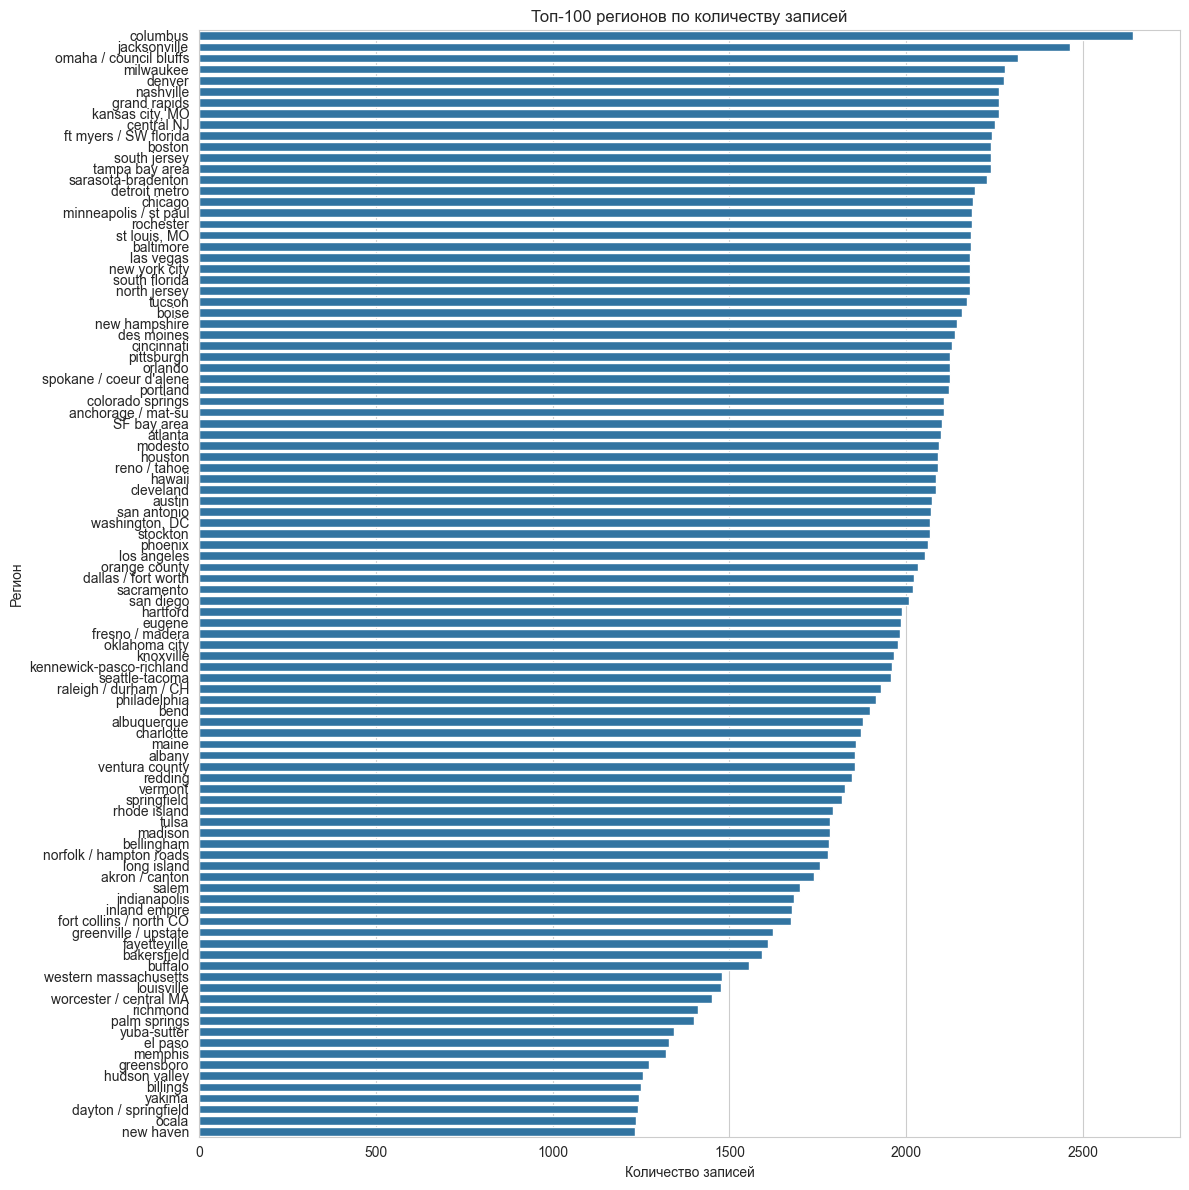

In [ ]:
region_counts = df_train_clean['region'].value_counts()

top100 = region_counts.head(100)

plt.figure(figsize=(12, 12))
sns.barplot(x=top100.values, y=top100.index)
plt.xlabel('Количество записей')
plt.ylabel('Регион')
plt.title('Топ-100 регионов по количеству записей')
plt.tight_layout()
plt.show()

### Заметим,что вариантивность регионов очень большая возможно в будущем будет целесообразно выделить редко встречающиеся регионы в отдельную категорию.

## 7.2 Рассмотрим производителей

In [87]:
print('Количество уникальных производителей:',len(df_train_clean['manufacturer'].unique()))

Количество уникальных производителей: 43


### Заметим,что количество производителей небольшое,следовательно можно не выделять в отдельные подгруппы

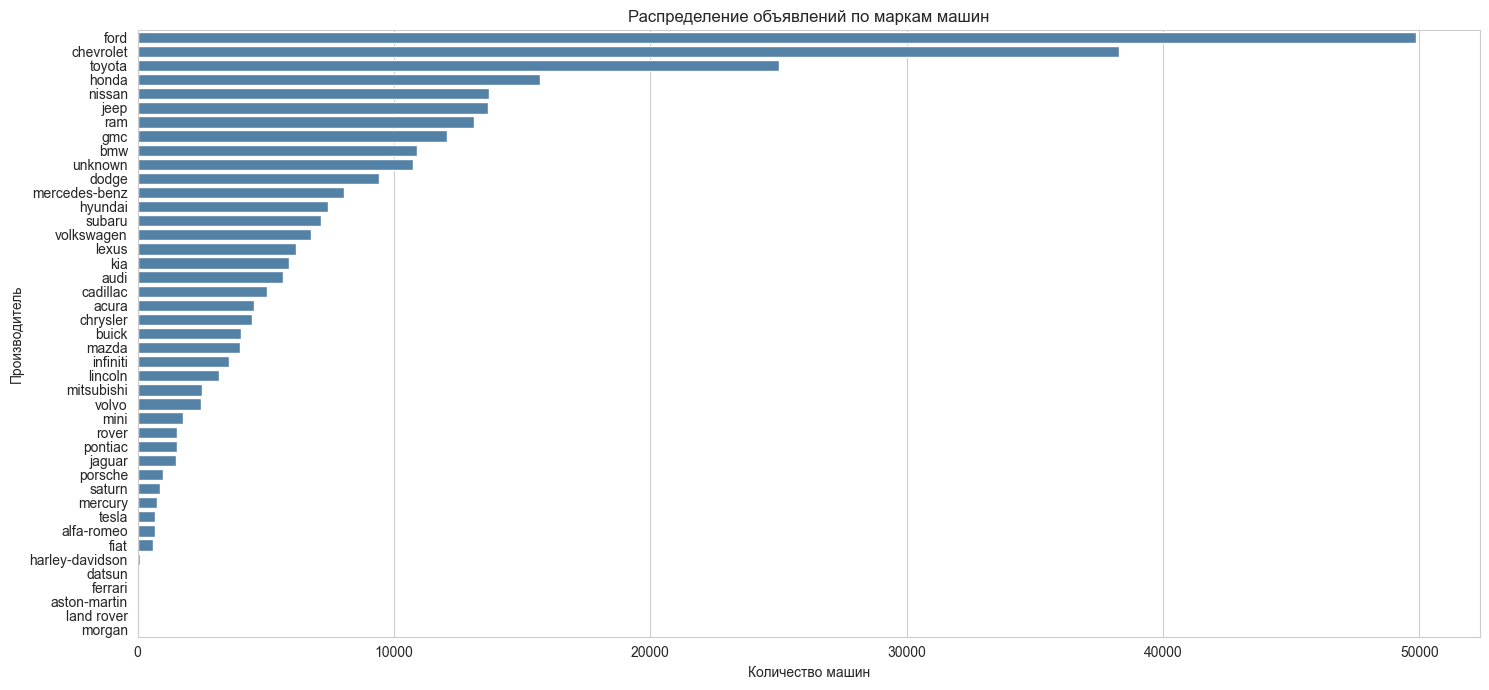

In [88]:

manufacturer_counts = df_train_clean['manufacturer'].value_counts()

plt.figure(figsize=(15, 7))
sns.barplot(x=manufacturer_counts.values, y=manufacturer_counts.index, color="steelblue")
plt.xlabel('Количество машин')
plt.ylabel('Производитель')
plt.title('Распределение объявлений по маркам машин')
plt.tight_layout()
plt.show()

### График показывает распределение количества объявлений по маркам автомобилей. Наиболее популярные производители заметно выделяются по количеству объявлений, а менее распространённые марки встречаются гораздо реже.

## 7.3 Рассмотрим модели 

In [89]:
print('Количество уникальных моделей:',len(df_train_clean['model'].unique()))

Количество уникальных моделей: 23198


###  Видим, что уникальных моделей очень много,поэтому воспользуемся аналогичным подходом,как и с регионами.Возьмём 250-500 самых популярных моделей,а все отсальные отнесем в отдельную категорию

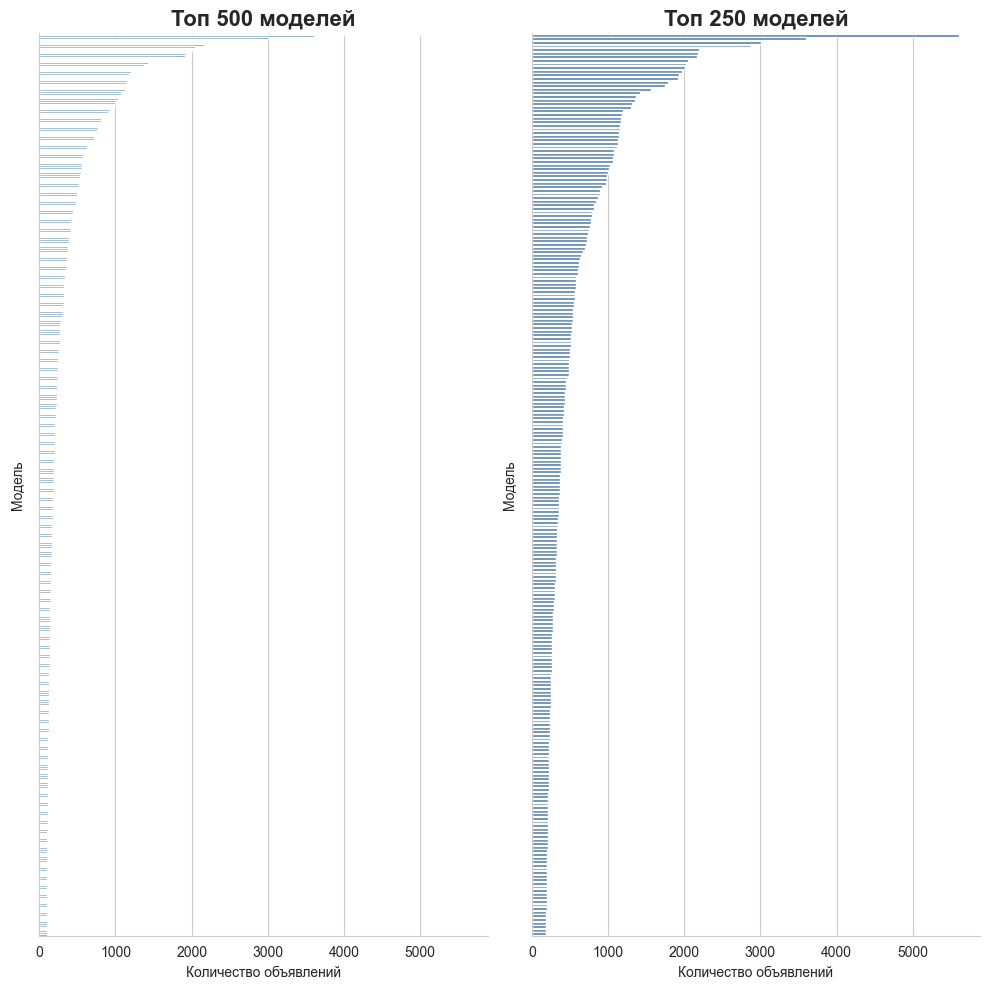

In [90]:
model_counts = df_train_clean['model'].value_counts()
top500 = model_counts.head(500)
top250 = model_counts.head(250)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
sns.set_style("whitegrid")

sns.barplot(x=top500.values, y=top500.index, color="steelblue", ax=ax[0])
ax[0].set_title("Топ 500 моделей", fontsize=16, fontweight='bold')
ax[0].set_xlabel("Количество объявлений")
ax[0].set_ylabel("Модель")
ax[0].set_yticklabels([])

sns.barplot(x=top250.values, y=top250.index, color="steelblue", ax=ax[1])
ax[1].set_title("Топ 250 моделей", fontsize=16, fontweight='bold')
ax[1].set_xlabel("Количество объявлений")
ax[1].set_ylabel("Модель")
ax[1].set_yticklabels([])

sns.despine()
plt.tight_layout()
plt.show()


### Видим, что у топ 500 моделей имеется огромный хвост со знаечениями стремящимся к нулю,поэтому будет более целесообразно выбрать топ 250 моделей.

# !!!! Доработать категориальные !!!!!

# 8. Поработаем с "временными" признаками

### Ранее временной признак мы разбили на несколько.Изучим их взаимосвзяь с целевой переменной

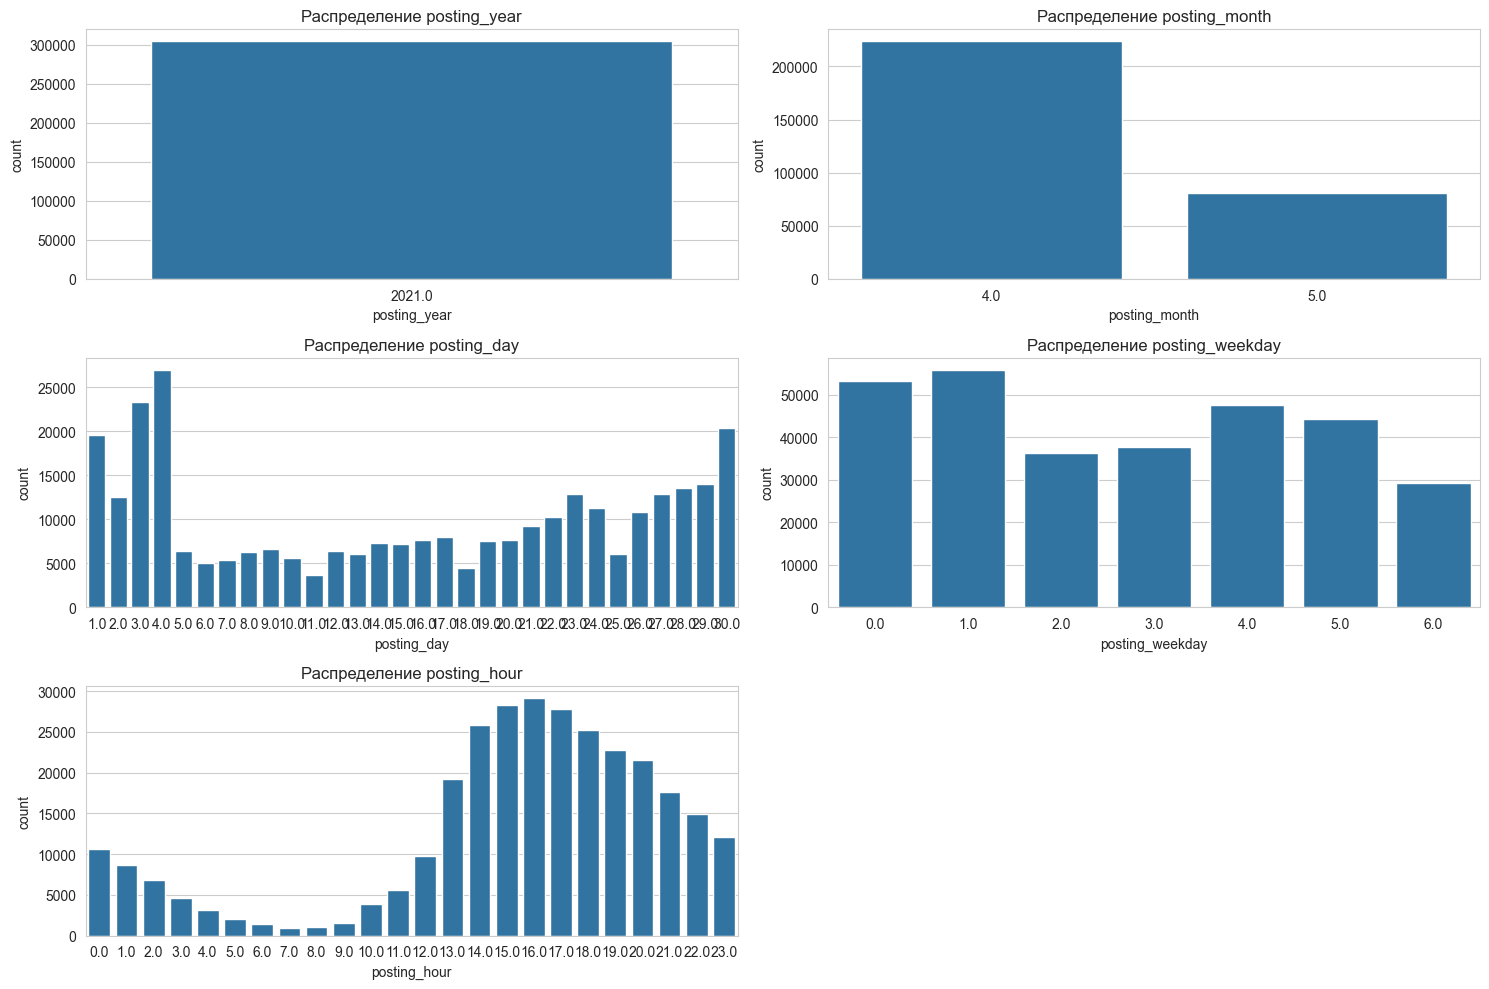

In [92]:
time_features = ['posting_year', 'posting_month', 'posting_day', 'posting_weekday', 'posting_hour']

plt.figure(figsize=(15,10))
for i, col in enumerate(time_features, 1):
    plt.subplot(3, 2, i)
    sns.countplot(x=col, data=df_train_clean)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

### Можно сделать вывод,что posting_year является неинформативной колонкой,тк содержит в себе только 1 униккальное значение,можем удалить её.Также явно видимо,что вечером активность публикаций намного выше

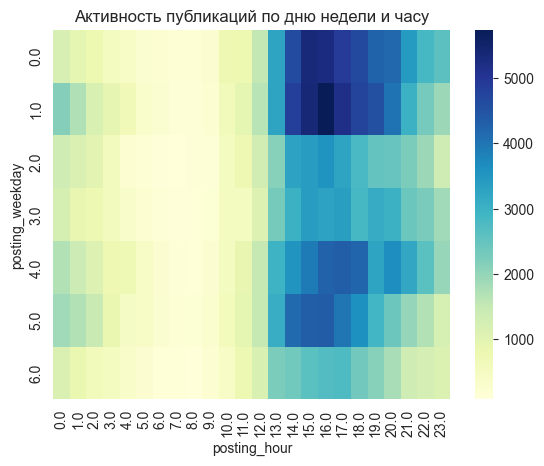

In [93]:
pivot_table = df_train_clean.pivot_table(index='posting_weekday', columns='posting_hour', values='price', aggfunc='count')
sns.heatmap(pivot_table, cmap='YlGnBu')
plt.title('Активность публикаций по дню недели и часу')
plt.show()

### Нашу гипотезу о активности пользователей сайта видим и на данной тепловой карте

# Вывод

На основе анализа можно сделать вывод, что целевая переменная имеет значительный разброс и ненормальное распределение, поэтому при обучении моделей целесообразно применить логарифмирование, чтобы снизить влияние экстремальных значений и улучшить стабильность предсказаний.

Анализ корреляций и визуализаций показал наличие информативных признаков, с которыми стоит продолжить работу, а также некоторых неинформативных или избыточных переменных, которые можно будет исключить или объединить на этапе feature engineering.

Также по графикам распределений и boxplot’ам видно, что в данных присутствуют выбросы, поэтому очистка набора данных необходима, но должна проводиться осторожно, чтобы не потерять редкие, но потенциально важные наблюдения (например, дорогие автомобили или редкие комплектации).

Следующим шагом будет построение новых признаков и извлечение максимума информации из имеющихся данных (создание нелинейных комбинаций, нормализация, работа с категориальными переменными и тд).

При дальнейшем моделировании для оценки качества можно рассматривать несколько метрик — например, MAE  для оценки точности в денежных единицах и RMSLE для оценки качества предсказаний в относительных величинах. Это позволит объективно оценить качество модели при наличии значительного разброса цен и предотвратить доминирование ошибок по дорогим экземплярам.